In [9]:
from sktime.classification.hybrid import HIVECOTEV2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sktime")
from src.recording_generator import RecordingGenerator

## functions

In [3]:
def plot_labels(X,y):
    label_0_indices = np.where(y == 0)[0]
    label_1_indices = np.where(y == 1)[0]

    # Select 5 cases from each label
    n_samples_to_plot = 5
    label_0_samples = label_0_indices[:n_samples_to_plot]
    label_1_samples = label_1_indices[:n_samples_to_plot]

    # Create a plot for both labels
    plt.figure(figsize=(10, 6))

    # Plot 5 cases from label 0
    for idx in label_0_samples:
        plt.plot(X[idx, 0, :], label=f"Label 0 - Sample {idx}", color='pink', alpha=0.6)

    # Plot 5 cases from label 1
    for idx in label_1_samples:
        plt.plot(X[idx, 0, :], label=f"Label 1 - Sample {idx}", color='olive', alpha=0.4)

    # Add legend and labels
    plt.title('5 Instances of Each Label')
    plt.xlabel('Time Index')
    plt.ylabel('Value')
    plt.legend(loc="upper right")
    plt.tight_layout()

    # Show plot
plt.show()

In [4]:
def plot_incorrect_classifications(data_test, labels_test, y_pred, num_samples=10):
    """
    Plot incorrectly classified samples with true and predicted labels, colored by true label.

    Parameters:
    - data_test: The test dataset (3D array).
    - labels_test: True labels for the test dataset.
    - y_pred: Predicted labels for the test dataset.
    - num_samples: Number of incorrectly classified samples to plot.
    """
    # Identify incorrectly classified indices
    incorrect_indices = np.where(labels_test != y_pred)[0]

    # Limit to the specified number of incorrectly classified instances
    num_plots = min(num_samples, len(incorrect_indices))
    
    if num_plots == 0:
        print("No incorrectly classified samples to plot.")
        return

    # Create a color map for the labels
    unique_labels = np.unique(labels_test)
    colors = plt.cm.get_cmap('Set3', len(unique_labels))  # Use a colormap with distinct colors

    # Create a figure for the plot
    plt.figure(figsize=(10, 5))
    
    for i, index in enumerate(incorrect_indices[:num_plots]):
        # Get the color for the true label
        color = colors(labels_test[index])
        plt.plot(data_test[index].flatten(), label=f'True: {labels_test[index]}, Predicted: {y_pred[index]}', color=color)

    plt.title('Incorrectly Classified Samples')
    plt.xlabel('Time Points')
    plt.ylabel('Value')
    plt.axhline(0, color='black', lw=0.5, ls='--')  # Add a horizontal line at y=0
    plt.legend()
    plt.tight_layout()
    plt.show()


In [10]:
def conf_matrix(y_test,y_pred):
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

## Hivecote

In [23]:
#data, labels, _ = make_dataset(AP_amplitude_mean_std_pct=[1, 0.2])
import os

dataset = '../simulated_data/DS_-10_30_10'
data = np.load(os.path.join(dataset, "X.npy"))
labels = (np.load(os.path.join(dataset, "y_reg.npy")) > 5).astype(int)

In [24]:
# Shuffle the data and create train-test split
data_train, data_test, labels_train, labels_test = train_test_split(
    data, labels, test_size=0.2, random_state=42, stratify=labels
)
data_train_3d = data_train[:, np.newaxis, :]  # Shape: (8000, 1, 200)
data_test_3d = data_test[:, np.newaxis, :]    # Shape: (2000, 1, 200)

# Convert labels to pandas Series
labels_train_series = pd.Series(labels_train)
labels_test_series = pd.Series(labels_test)

In [25]:
classifier = HIVECOTEV2(time_limit_in_minutes=3,verbose=1)
classifier.fit(data_train_3d, labels_train_series)
y_pred = classifier.predict(data_test_3d)

# Evaluate accuracy
accuracy = accuracy_score(labels_test_series, y_pred)
print(f"Accuracy: {accuracy}")

STC  14:26:50 09/12/2024
STC train estimate  14:26:58 09/12/2024
STC weight = 0.1095507211395359
DrCIF  14:30:46 09/12/2024
DrCIF train estimate  14:30:50 09/12/2024
DrCIF weight = 0.17953832392045016
Arsenal  14:33:53 09/12/2024
Arsenal train estimate  14:34:01 09/12/2024
Arsenal weight = 0.06172240448594092


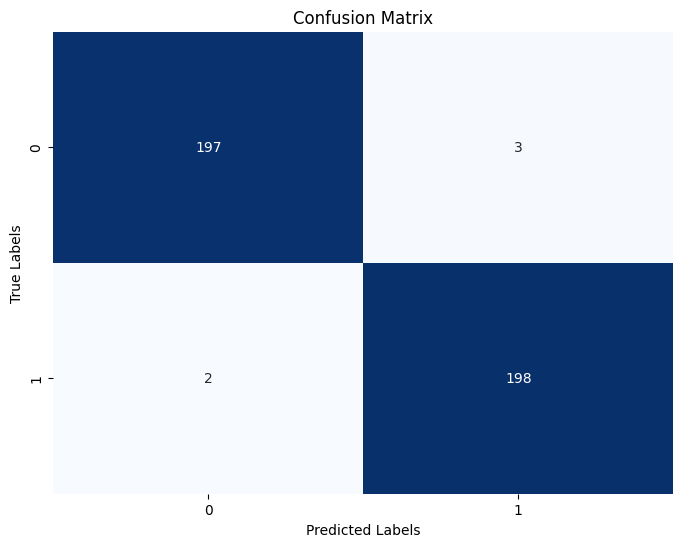

In [16]:
conf_matrix(labels_test_series, y_pred)

/tmp/ipykernel_14518/879086309.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set3', len(unique_labels))  # Use a colormap with distinct colors


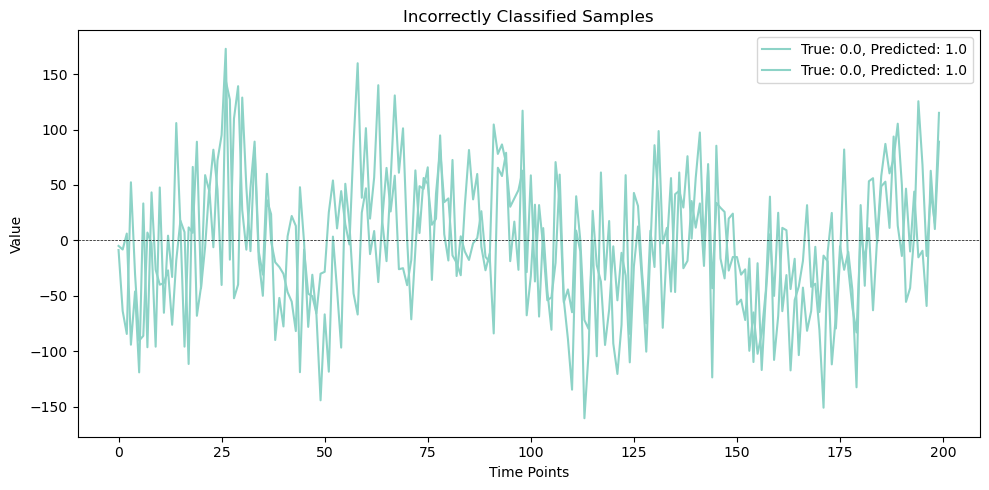

In [41]:
plot_incorrect_classifications(data_test_3d,labels_test,y_pred)